In [1]:
#Python libraries
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

In [2]:
#check tensorflow version
print(tf.__version__)

2.12.0


In [3]:
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

False


In [4]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [5]:
#show terminal info
terminal_info=mt5.terminal_info()
print(terminal_info)

TerminalInfo(community_account=True, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=4468, maxbars=100000, codepage=0, ping_last=57965, community_balance=0.0, retransmission=0.0, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\Msyne\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\Msyne\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [6]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"
print(file_path)

C:\Users\Msyne\AppData\Roaming\MetaQuotes\Terminal\53785E099C927DB68A545C249CDBCE06\MQL5\Files\


In [7]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]
print("data path to save onnx model",data_path)

data path to save onnx model C:\Users\Msyne\AppData\Roaming\Python\Python310\site-packages\


In [8]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2024-05-01 13:10:42.987646
data end date= 2024-08-29 13:10:42.987646


In [9]:
#get xauusd rates (H1) from start_date to end_date
xauusd_rates = mt5.copy_rates_range("XAUUSDm", mt5.TIMEFRAME_H1, start_date, end_date)

In [10]:
#check
print(xauusd_rates)

[(1714546800, 2286.88 , 2287.957, 2283.484, 2285.785, 4455, 199, 0)
 (1714550400, 2285.735, 2286.788, 2283.799, 2286.189, 4389, 199, 0)
 (1714554000, 2286.244, 2293.087, 2285.672, 2291.891, 4993, 199, 0) ...
 (1724904000, 2516.591, 2518.213, 2515.501, 2515.891, 4340, 160, 0)
 (1724907600, 2515.855, 2519.93 , 2513.806, 2518.728, 5343, 159, 0)
 (1724911200, 2518.695, 2520.048, 2517.681, 2519.178, 1067, 160, 0)]


In [11]:
#create dataframe
df = pd.DataFrame(xauusd_rates)

In [12]:
#show dataframe head
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1714546800,2286.880,2287.957,2283.484,2285.785,4455,199,0
1,1714550400,2285.735,2286.788,2283.799,2286.189,4389,199,0
2,1714554000,2286.244,2293.087,2285.672,2291.891,4993,199,0
3,1714557600,2291.873,2294.339,2289.100,2293.117,4806,199,0
4,1714561200,2293.127,2297.093,2291.366,2294.538,4724,199,0


In [13]:
#show dataframe tail
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
1964,1724896800,2513.182,2515.203,2511.603,2512.842,4956,159,0
1965,1724900400,2512.812,2516.771,2512.352,2516.543,4328,159,0
1966,1724904000,2516.591,2518.213,2515.501,2515.891,4340,160,0
1967,1724907600,2515.855,2519.930,2513.806,2518.728,5343,159,0
1968,1724911200,2518.695,2520.048,2517.681,2519.178,1067,160,0


In [14]:
#show dataframe shape (the number of rows and columns in the data set)
df.shape

(1969, 8)

In [15]:
#prepare close prices only
data = df.filter(['close']).values

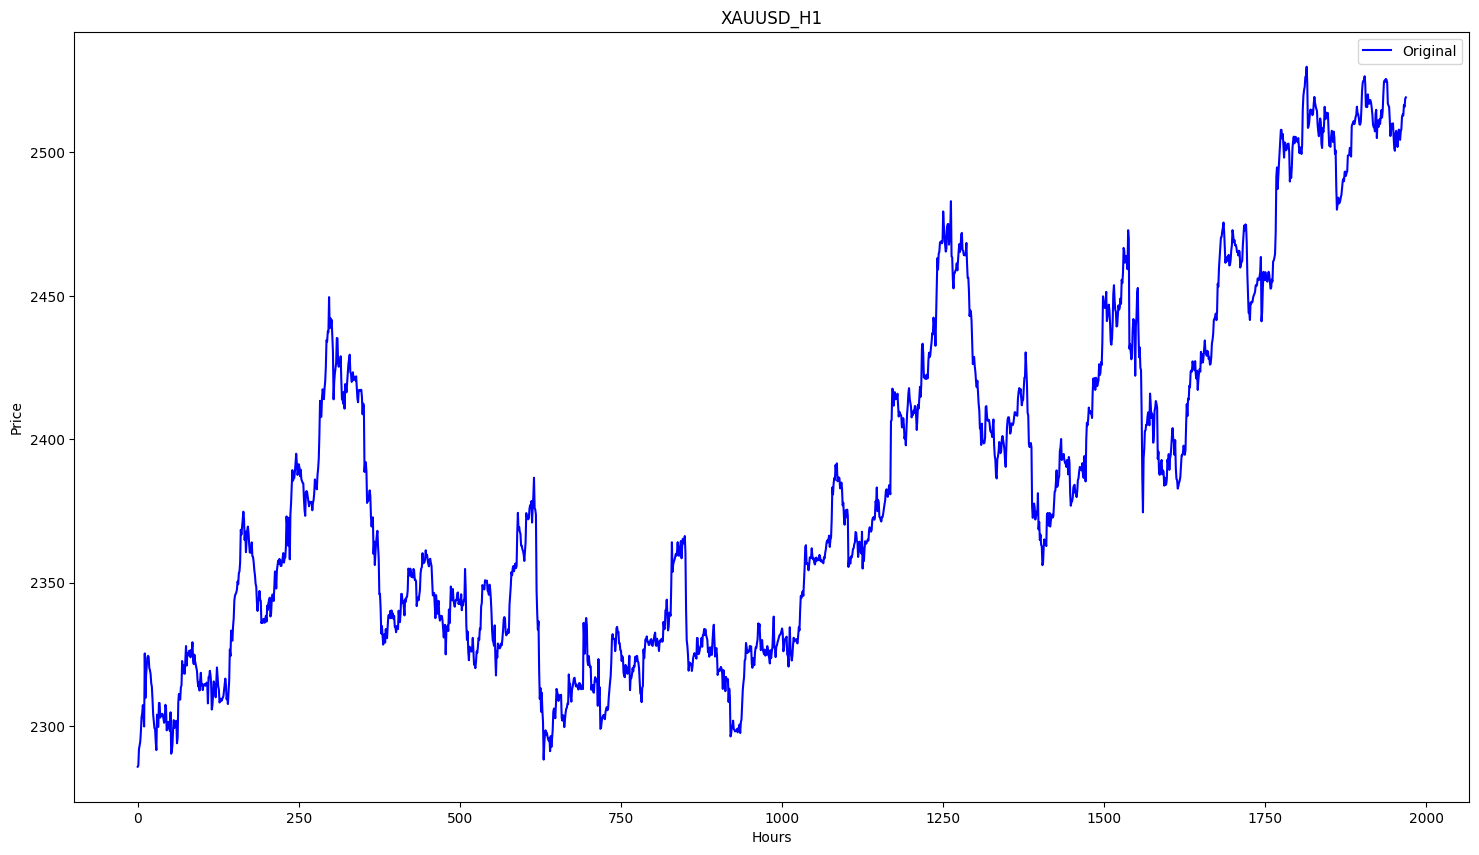

In [16]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.ylabel("Price")
plt.title("XAUUSD_H1")
plt.legend()

In [17]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [18]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1575


In [19]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

1575


In [20]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

394


In [21]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [23]:
#show shape of train data
x_train.shape

(1455, 120, 1)

In [24]:
#show shape of test data
x_test.shape

(274, 120, 1)

In [25]:
#import keras libraries for the model
import math
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.utils.vis_utils import plot_model

from tensorflow.python.keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers


In [26]:
#define the model
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
#model.add(tf.keras.layers.LSTM(100, return_sequences = True))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.LSTM(100, return_sequences = False))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
#model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

# Get layer names
#output_names = [layer.name for layer in model.layers]

#print(output_names)

#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [27]:
#show model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 120, 256)          768       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 100)           142800    
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [28]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 300 epochs
history=model.fit(x_train,y_train,epochs=300,validation_data=(x_test,y_test),batch_size=32,verbose=1)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/300
46/46 [==============================] - 17s 190ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1874
Epoch 2/300
46/46 [==============================] - 8s 185ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 3/300
46/46 [==============================] - 8s 177ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 4/300
46/46 [==============================] - 8s 165ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 5/300
46/46 [==============================] - 7s 158ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 6/300
46/46 [==============================] - 7s 159ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0099

In [29]:
#show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

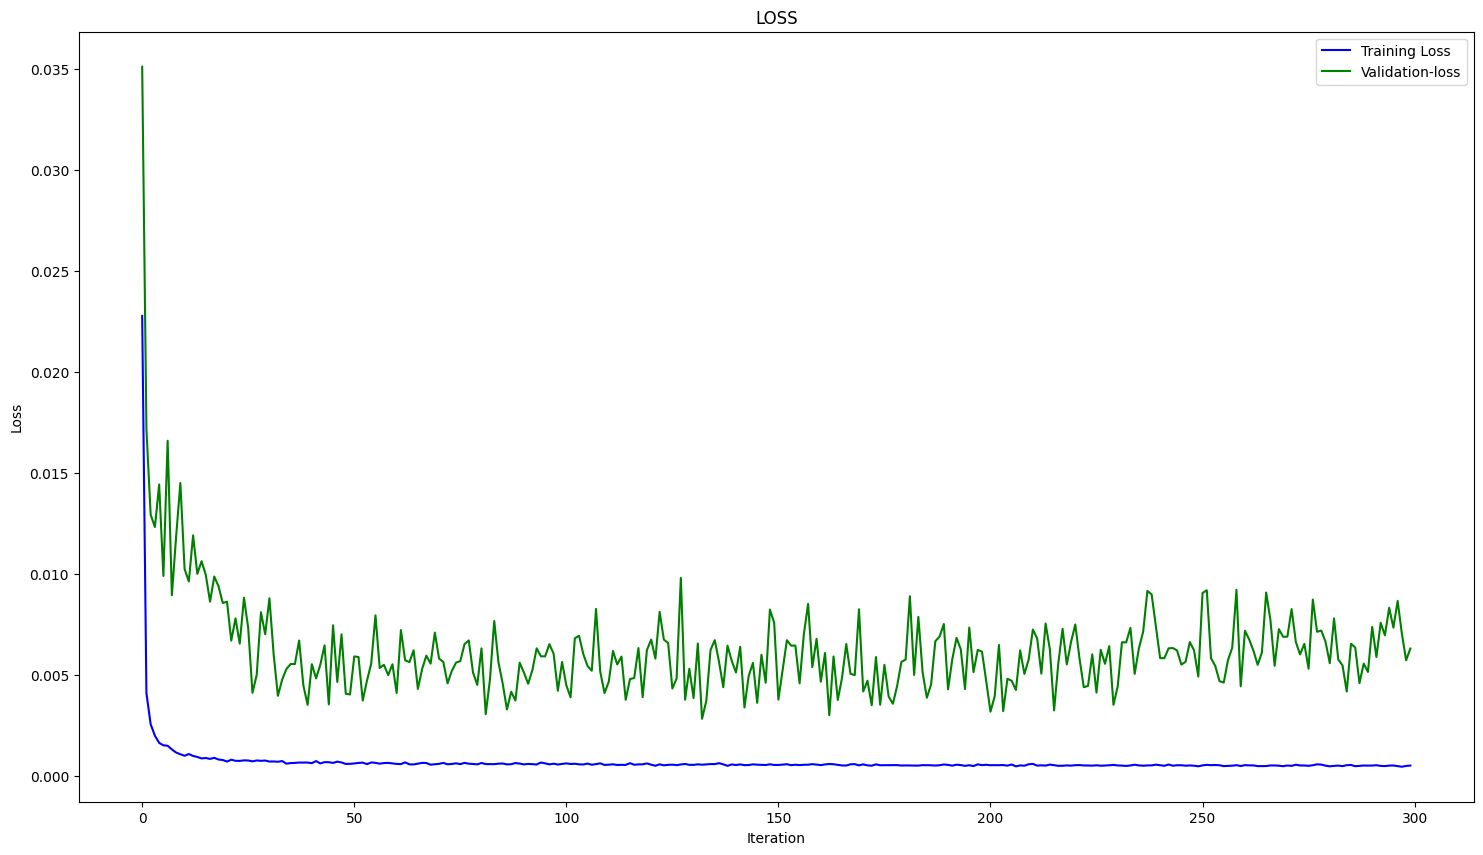

In [30]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LOSS")
plt.legend()

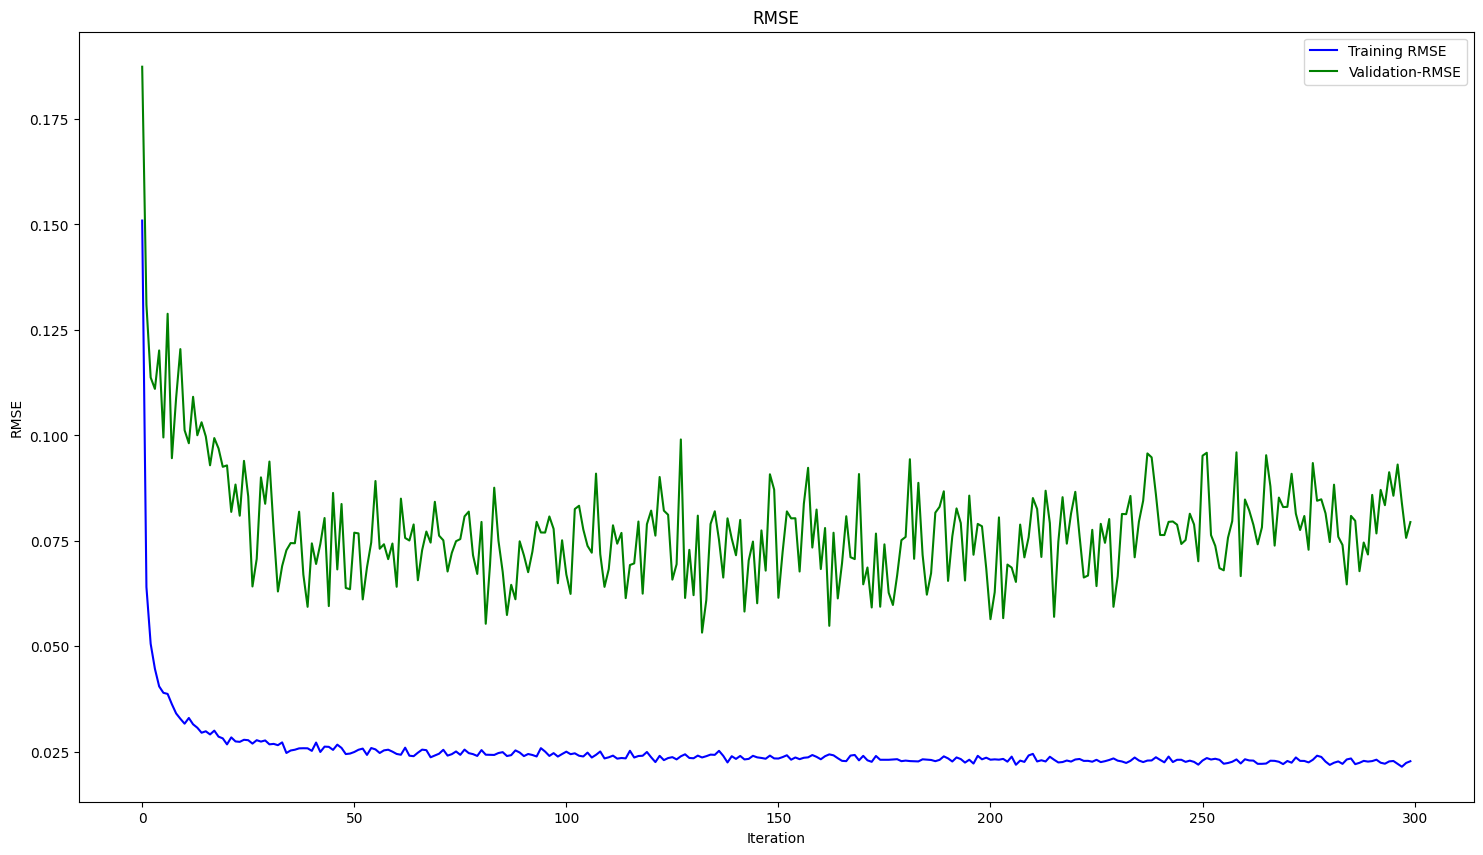

In [31]:
#show iteration-rmse graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE',color='b')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation-RMSE',color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE")
plt.legend()

In [32]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

46/46 [==============================] - 2s 48ms/step - loss: 4.3621e-04 - root_mean_squared_error: 0.0209


[0.0004362074250821024, 0.02088557928800583]

In [33]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

9/9 [==============================] - 0s 47ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795


[0.006315088830888271, 0.0794675350189209]

In [34]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

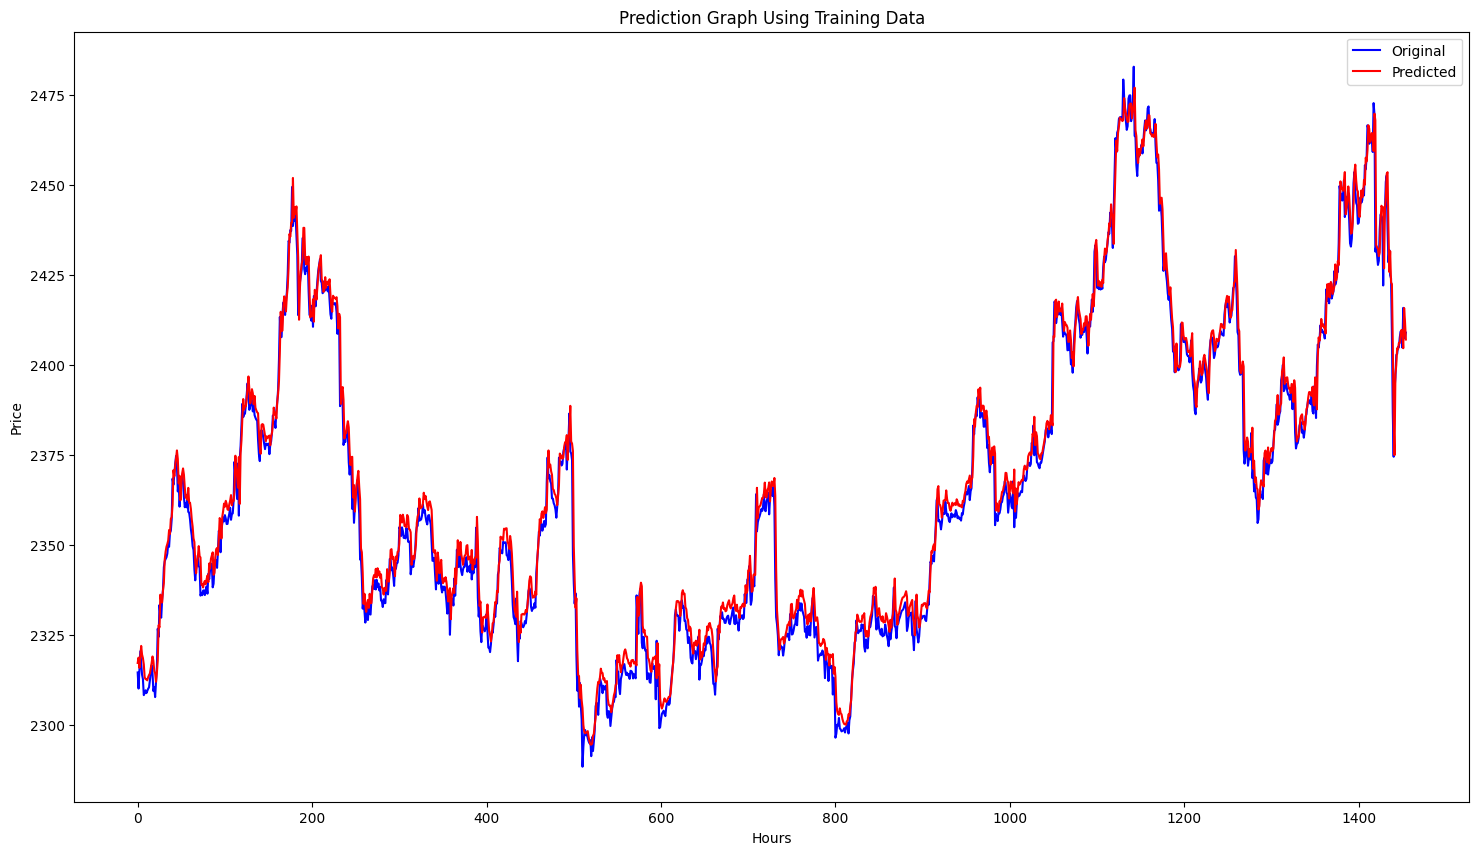

In [35]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [36]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

In [37]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 19.396357091154293
MSE          : 376.2186684075714
R2 score     : 0.31817676417012986


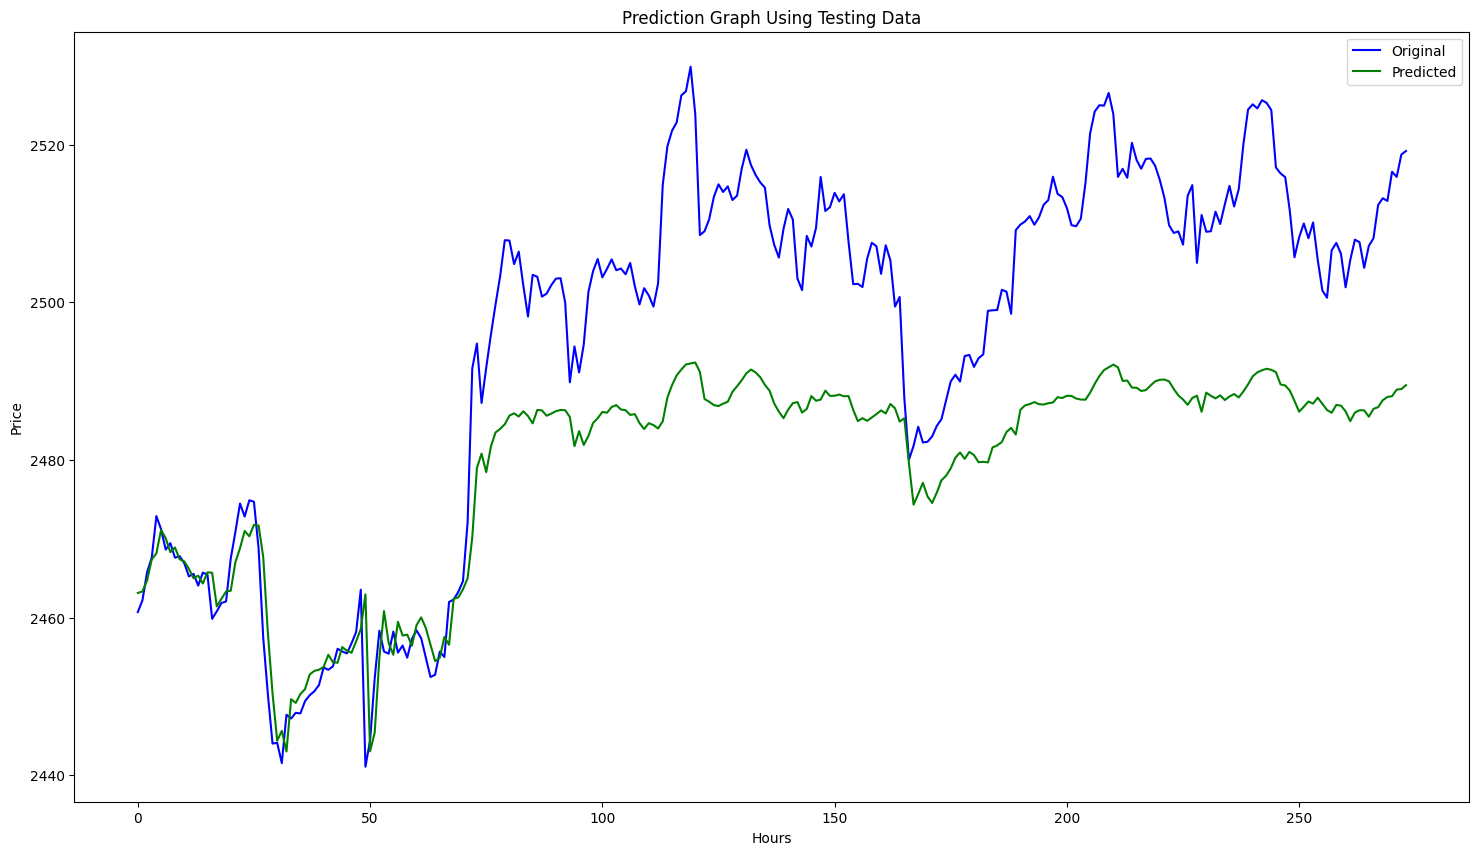

In [38]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [39]:
# save model to ONNX
output_path = data_path+"model.xauusd.H1.120.onnx"
#onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"model saved to {output_path}")

output_path = file_path+"model.xauusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"saved model to {output_path}")

# finish
mt5.shutdown()


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
model saved to C:\Users\Msyne\AppData\Roaming\Python\Python310\site-packages\model.xauusd.H1.120.onnx
saved model to C:\Users\Msyne\AppData\Roaming\MetaQuotes\Terminal\53785E099C927DB68A545C249CDBCE06\MQL5\Files\model.xauusd.H1.120.onnx


True